# XAI | Mechanistic Interpretability


Description: 

by Christian Moreira(chris.moreira@duke.edu)

[![GitHub Repo](https://img.shields.io/badge/GitHub-Repo-black.svg?logo=github&style=for-the-badge)](https://github.com/U1186204/Mechanistic-Interpretability/tree/main)

[![Open In Colab](https://img.shields.io/badge/Open%20In-Colab-F9AB00.svg?logo=googlecolab&style=for-the-badge)](https://colab.research.google.com/github/U1186204/Mechanistic-Interpretability/blob/main/main.ipynb)



### Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
import string
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

### Data Generation

In [2]:
SEQ_LENGTH = 5
VOCAB = string.ascii_lowercase
VOCAB_SIZE = len(VOCAB)

char_to_idx = {char: i for i, char in enumerate(VOCAB)}
idx_to_char = {i: char for i, char in enumerate(VOCAB)}

def one_hot_encode(sequence, vocab_size):
    tensor = torch.zeros(len(sequence), vocab_size)
    for i, char in enumerate(sequence):
        tensor[i, char_to_idx[char]] = 1
    return tensor

def generate_data(n_samples, seq_length):
    X = []
    y = []
    for _ in range(n_samples):
        input_seq = ''.join(random.choices(VOCAB, k=seq_length))
        output_seq = input_seq[::-1]
        
        X.append(one_hot_encode(input_seq, VOCAB_SIZE))
        y.append(torch.tensor([char_to_idx[char] for char in output_seq], dtype=torch.long))
    
    return torch.stack(X), torch.stack(y)

### Generating + Loading Data

In [3]:
BATCH_SIZE = 64
HIDDEN_DIM = 64
N_LAYERS = 1
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train_tensor, y_train_tensor = generate_data(10000, SEQ_LENGTH)
X_val_tensor, y_val_tensor = generate_data(1000, SEQ_LENGTH)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

print(f"Device: {DEVICE}")
print(f"X_train shape: {X_train_tensor.shape}")
print(f"y_train shape: {y_train_tensor.shape}")

Device: cpu
X_train shape: torch.Size([10000, 5, 26])
y_train shape: torch.Size([10000, 5])


### Defining Encoding & Decoding in Model

In [4]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.rnn = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True)
        
    def forward(self, src):
        outputs, hidden = self.rnn(src)
        return hidden

class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, n_layers):
        super().__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.rnn = nn.GRU(output_dim, hidden_dim, n_layers, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.embedding = nn.Embedding(output_dim, output_dim)
        self.embedding.weight.data = torch.eye(output_dim)
        self.embedding.weight.requires_grad = False
        
    def forward(self, input, hidden):
        input = input.unsqueeze(1)
        embedded = self.embedding(input)
        output, hidden = self.rnn(embedded, hidden)
        prediction = self.fc_out(output.squeeze(1))
        return prediction, hidden

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim
        
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)
        encoder_hidden = self.encoder(src)
        
        decoder_hidden = encoder_hidden
        
        input = trg[:, 0]
        
        decoder_hiddens = []
        
        for t in range(trg_len):
            decoder_output, decoder_hidden = self.decoder(input, decoder_hidden)
            outputs[:, t] = decoder_output
            
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = decoder_output.argmax(1) 
            input = trg[:, t] if teacher_force else top1
            
            decoder_hiddens.append(decoder_hidden.squeeze(0))

        return outputs, encoder_hidden, torch.stack(decoder_hiddens)

### Instantiate Model and Optimizer

In [5]:
encoder = Encoder(VOCAB_SIZE, HIDDEN_DIM, N_LAYERS)
decoder = Decoder(VOCAB_SIZE, HIDDEN_DIM, N_LAYERS)
model = Seq2Seq(encoder, decoder, DEVICE).to(DEVICE)

optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (rnn): GRU(26, 64, batch_first=True)
  )
  (decoder): Decoder(
    (rnn): GRU(26, 64, batch_first=True)
    (fc_out): Linear(in_features=64, out_features=26, bias=True)
    (embedding): Embedding(26, 26)
  )
)

### Training Loop

In [6]:
N_EPOCHS = 25
CLIP = 1
train_losses = []

for epoch in range(N_EPOCHS):
    model.train()
    epoch_loss = 0
    
    for i, (src, trg) in enumerate(train_loader):
        src = src.to(DEVICE)
        trg = trg.to(DEVICE)
        
        optimizer.zero_grad()
        
        output, _, _ = model(src, trg)
        
        output_dim = output.shape[-1]
        output = output.view(-1, output_dim)
        trg = trg.view(-1)
        
        loss = criterion(output, trg)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP)
        optimizer.step()
        
        epoch_loss += loss.item()
        
    train_loss = epoch_loss / len(train_loader)
    train_losses.append(train_loss)
    
    if (epoch+1) % 5 == 0:
        print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f}')

Epoch: 05 | Train Loss: 1.844
Epoch: 10 | Train Loss: 0.549
Epoch: 15 | Train Loss: 0.121
Epoch: 20 | Train Loss: 0.040
Epoch: 25 | Train Loss: 0.016


### Training Loss

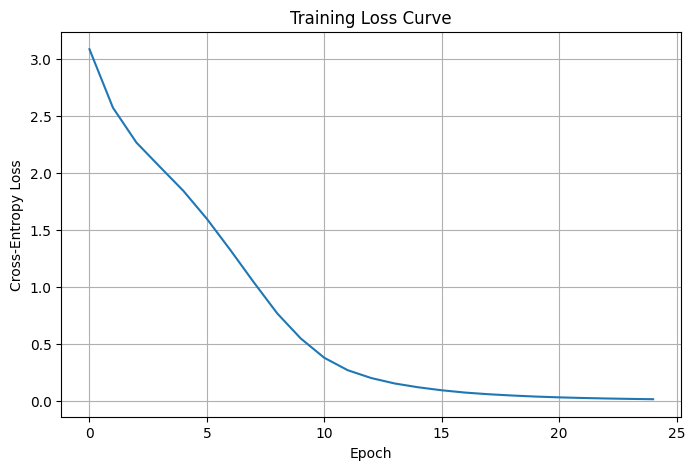

In [7]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()

### Evaluation Fucntion

In [8]:
def predict_sequence(model, input_str, device):
    model.eval()
    with torch.no_grad():
        input_tensor = one_hot_encode(input_str, VOCAB_SIZE).unsqueeze(0).to(device)
        target_tensor = torch.zeros(1, SEQ_LENGTH, dtype=torch.long).to(device)
        
        outputs_tensor, context_vector, decoder_hiddens = model(input_tensor, target_tensor, teacher_forcing_ratio=0)
        
        outputs = outputs_tensor.squeeze(0).argmax(1).cpu().numpy()
        output_str = ''.join([idx_to_char[idx] for idx in outputs])
        
    return output_str, context_vector, decoder_hiddens

def calculate_accuracy(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for src, trg in loader:
            src = src.to(device)
            trg = trg.to(device)
            
            output, _, _ = model(src, trg, teacher_forcing_ratio=0)
            
            output_dim = output.shape[-1]
            output = output.view(-1, output_dim)
            trg = trg.view(-1)
            
            preds = output.argmax(1)
            correct += (preds == trg).sum().item()
            total += trg.shape[0]
            
    return 100 * (correct / total)

### Runnning Evaluation

In [9]:
val_accuracy = calculate_accuracy(model, val_loader, DEVICE)
print(f'Validation Character Accuracy: {val_accuracy:.2f}%')

print("\n--- Sample Predictions ---")
test_words = ['hello', 'world', 'torch', 'three', 'basic']
for word in test_words:
    prediction, _, _ = predict_sequence(model, word, DEVICE)
    print(f"Input: '{word}' | Pred: '{prediction}' | True: '{word[::-1]}'")

Validation Character Accuracy: 99.50%

--- Sample Predictions ---
Input: 'hello' | Pred: 'olleh' | True: 'olleh'
Input: 'world' | Pred: 'dlrow' | True: 'dlrow'
Input: 'torch' | Pred: 'hcrot' | True: 'hcrot'
Input: 'three' | Pred: 'eerht' | True: 'eerht'
Input: 'basic' | Pred: 'cisab' | True: 'cisab'


### Context Vector Visual

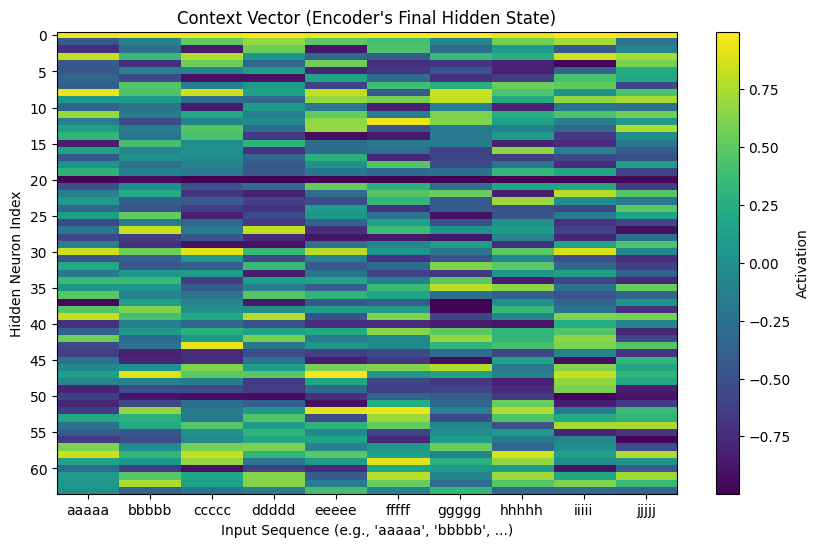

In [10]:
test_chars = VOCAB[:10]
context_vectors = []
labels = []

for char in test_chars:
    input_str = char * SEQ_LENGTH
    _, context, _ = predict_sequence(model, input_str, DEVICE)
    context_vectors.append(context.squeeze().cpu().numpy())
    labels.append(input_str)

context_vectors = np.array(context_vectors)

plt.figure(figsize=(10, 6))
plt.imshow(context_vectors.T, aspect='auto', cmap='viridis')
plt.yticks(range(0, HIDDEN_DIM, 5))
plt.xticks(range(len(labels)), labels)
plt.xlabel("Input Sequence (e.g., 'aaaaa', 'bbbbb', ...)")
plt.ylabel("Hidden Neuron Index")
plt.title("Context Vector (Encoder's Final Hidden State)")
plt.colorbar(label="Activation")
plt.show()

### Decoder Hidden States Visual

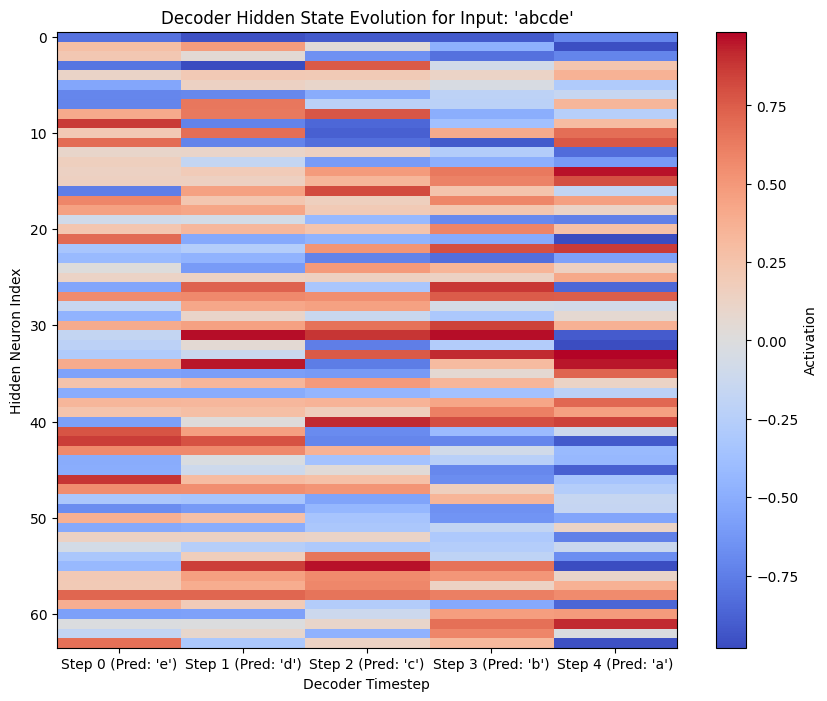

In [11]:
input_str = 'abcde'
prediction, _, decoder_hiddens = predict_sequence(model, input_str, DEVICE)
decoder_hiddens_np = decoder_hiddens.squeeze().cpu().numpy()

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(decoder_hiddens_np.T, cmap='coolwarm', aspect='auto')

ax.set_xticks(range(SEQ_LENGTH))
ax.set_xticklabels([f"Step {i} (Pred: '{prediction[i]}')" for i in range(SEQ_LENGTH)])
ax.set_xlabel("Decoder Timestep")
ax.set_ylabel("Hidden Neuron Index")
ax.set_title(f"Decoder Hidden State Evolution for Input: '{input_str}'")

fig.colorbar(im, ax=ax, label="Activation")
plt.show()

### Context Vector Ablation

In [12]:
def get_char_accuracy(s1, s2):
    return sum(c1 == c2 for c1, c2 in zip(s1, s2))

test_input = 'world'
true_output = test_input[::-1]

baseline_pred, base_context, _ = predict_sequence(model, test_input, DEVICE)
baseline_acc = get_char_accuracy(baseline_pred, true_output)

print(f"--- Ablation Test ---")
print(f"Input: '{test_input}' | True: '{true_output}'")
print(f"Baseline Pred: '{baseline_pred}' | Accuracy: {baseline_acc}/{SEQ_LENGTH}")

accuracy_drops = []
model.eval()
with torch.no_grad():
    for i in range(HIDDEN_DIM):
        
        ablated_context = base_context.clone()
        ablated_context[0, 0, i] = 0
        
        decoder_hidden = ablated_context
        
        decoder_input = torch.tensor([char_to_idx[true_output[0]]], device=DEVICE)
        
        ablated_outputs = []
        
        for t in range(SEQ_LENGTH):
            decoder_output, decoder_hidden = model.decoder(decoder_input, decoder_hidden)
            top1 = decoder_output.argmax(1)
            ablated_outputs.append(idx_to_char[top1.item()])
            decoder_input = top1
            
        ablated_pred = "".join(ablated_outputs)
        ablated_acc = get_char_accuracy(ablated_pred, true_output)
        accuracy_drops.append(baseline_acc - ablated_acc)
        
        if baseline_acc - ablated_acc > 1:
            print(f"Ablating Neuron {i:02d}: Pred: '{ablated_pred}' | Acc Drop: {baseline_acc - ablated_acc}")

--- Ablation Test ---
Input: 'world' | True: 'dlrow'
Baseline Pred: 'dlrow' | Accuracy: 5/5


### Ablation Results Plot

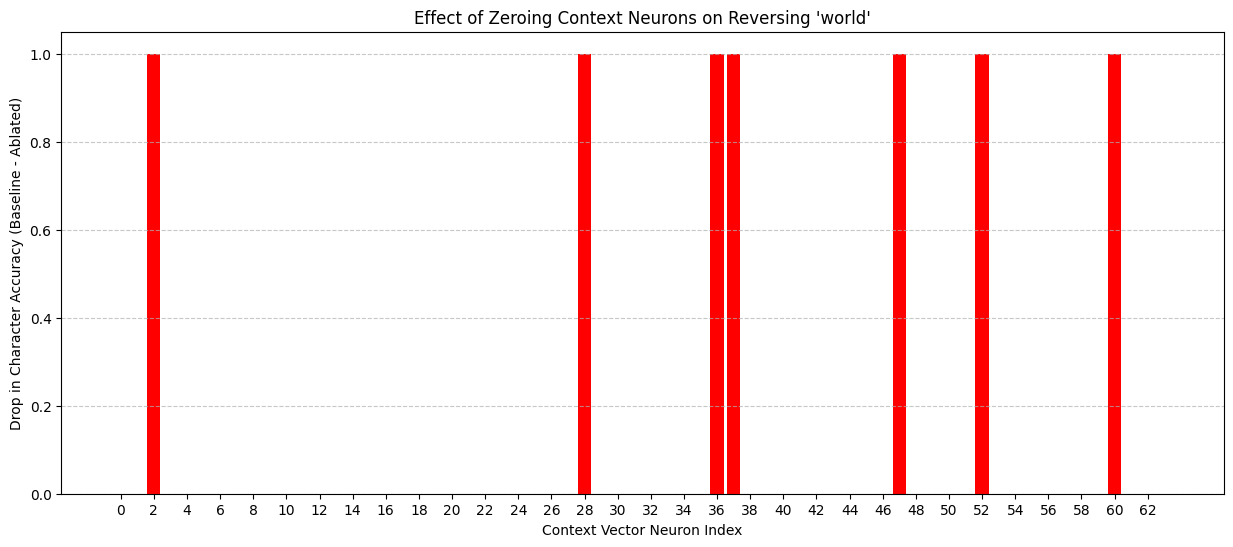

In [13]:
plt.figure(figsize=(15, 6))
colors = ['red' if d > 0 else 'gray' for d in accuracy_drops]

plt.bar(range(HIDDEN_DIM), accuracy_drops, color=colors)
plt.xlabel("Context Vector Neuron Index")
plt.ylabel("Drop in Character Accuracy (Baseline - Ablated)")
plt.title(f"Effect of Zeroing Context Neurons on Reversing '{test_input}'")
plt.xticks(range(0, HIDDEN_DIM, 2))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Reflection